In [90]:
import numpy as np
import pandas as pd
from numpy.random import uniform, normal  
import math
from math import pi
from scipy.optimize import Bounds
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

In [2]:
def J_square(sigma_square,tau_square):
    return tau_square/(tau_square+sigma_square)

In [3]:
# k: the number of studies
k_list = [10,30,50,100]
# each element of `parameter_constellation` has the form (mu, sigma^2,tau^2) 
# where tau^2 is the between-study variance, sigma^2*u_i is the within-study variance
parameter_constellation = [(0,12,4),(0,9,4),(0,4,4),(0,2,6)]
# heterogeniety measure: J^2
J_square_list = list()
for element in parameter_constellation:
    sigma_square_i = element[1]
    tau_square_i = element[2]
    J_square_list.append(J_square(sigma_square_i,tau_square_i))
print('J square =',J_square_list)

J square = [0.25, 0.3076923076923077, 0.5, 0.75]


## method1: trying to minimize the negative log likelihood

### The negative log-likelihood function of $v = (\mu, \sigma^2, \tau^2)$ is given by

$I(v) = \frac{1}{2}\sum \limits_{i=1}^{k}[\frac{(D_i-\mu)^2}{\tau^2+\sigma^2 u_i}+\log{(\tau^2+\sigma^2 u_i)}+c]$

with jacobian matrix (which cannot be calculated automatically in numpy):

$$\frac{\partial l(v)}{\partial \mu} = \sum \limits_{i=1}^{k} \frac{D_i - \mu}{\tau^2 + \sigma^2 u_i}$$

$$\frac{\partial l(v)}{\partial \sigma^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 u_i}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{u_i}{\tau^2+\sigma^2u_i} \Rightarrow \frac{\partial l(v)}{\partial \sigma} = \frac{\partial l(v)}{\partial \sigma^2} \cdot 2 \sigma = (\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 u_i}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{u_i}{\tau^2+\sigma^2u_i}) \cdot 2 \sigma$$

$$\frac{\partial l(v)}{\partial \tau^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i} \Rightarrow \frac{\partial l(v)}{\partial \tau} = \frac{\partial l(v)}{\partial \tau^2} \cdot 2 \tau = (\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2u_i}) \cdot 2 \tau$$

In [4]:
# define the negative log likelihood function
# minimize negative log likelihood function -> maximize log likelihood function
def nll(x, D, u):
    # x = np.array([mu, sigma, tau])
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    return 1/2*np.sum((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def jac(x, D, u):
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma = (np.sum((a**2 * u) / b**2) - np.sum(u / b)) * (2*sigma) 
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_sigma, d_tau])

def func(x, D, u):
    return nll(x, D, u), jac(x, D, u)

# mse(theta_hat, theta) = Var(theta_hat) + bias(theta_hat, theta)^2
def mse(param_ast,param):
    bias = np.mean(param_ast)-param
    mse = np.var(param_ast) + bias**2
    return mse

# summarize all the needed statistical infomation: [mean, bias, standard_deviation]
def stats_info(param_ast,param):
    result_list = [np.mean(param_ast)-param, np.std(param_ast), mse(param_ast,param)]
    return result_list

#############

def simulation(k, mu,sigma,tau,num_replications=10000):
    # store the results of convergent mu/sigma/tau for each replication
    actual_mu, actual_sigma_square,actual_tau_square = mu, sigma**2, tau**2
    
    all_mu_ast, all_sigma_square_ast, all_tau_square_ast = [], [], []

    for i in range(num_replications):
        # generate k(the number of studies) D_i
        u_array = uniform(0.02,0.2,k)
        u_inv_array = 1 / u_array
        # x_i ~ N(mu,tau^2)
        x_array = normal(mu,tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array,sigma*u_array**0.5,k)

        # Note that we cannot use the starting values suggested in Sangnawakij's paper
        # since given tau^2, sigma^2 and mu are calculated under the condition that the derivatives are zero
        # which leads to a stationary point

        # random but resonable initial point
        mu_0 = uniform(-2.0, 2.0)
        sigma_0 = uniform(0., 15.)
        tau_0 = uniform(0., 8.)
        x0 = np.array([mu_0, sigma_0, tau_0])
        minimizer = minimize(nll, x0, args=(D_array, u_array), method="BFGS", jac=jac, tol=1e-10)   
        #minimizer_kwargs = {"method": "BFGS", "args": (D_array, u_array), "jac":True}
        # corresponding mu/sigma/tau when the negative log likelihood function is minimized
        mu_ast, sigma_ast, tau_ast = minimizer.x
        sigma_square_ast = sigma_ast**2
        tau_square_ast = tau_ast**2
        # print("mu: {0}, sigma_square: {1}, tau_square: {2}".format(mu_ast, sigma_square_ast, tau_square_ast))
        all_mu_ast.append(mu_ast)
        all_sigma_square_ast.append(sigma_square_ast)
        all_tau_square_ast.append(tau_square_ast)

    # convert the list to numpy array
    all_mu_ast = np.array(all_mu_ast)
    all_sigma_square_ast = np.array(all_sigma_square_ast)
    all_tau_square_ast = np.array(all_tau_square_ast)
    
    # return the result for mu/sigma/tau in the form of: [mean, bias, std]
    mu_info = stats_info(all_mu_ast,actual_mu)
    sigma_square_info = stats_info(all_sigma_square_ast,actual_sigma_square)
    tau_square_info = stats_info(all_tau_square_ast,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])


### method 1: bounded optimisation using tau^2 and sigma^2
### (comparison to the code currently used in PyMARE)


In [11]:
def simulation_bounds(k, mu,sigma,tau,num_replications=10000):
    actual_mu, actual_sigma_square,actual_tau_square = mu, sigma**2, tau**2
    # store the results of convergent mu/sigma/tau for each replication
    all_mu_ast, all_sigma_square_ast, all_tau_square_ast = [], [], []

    for i in range(num_replications):
        # generate k(the number of studies) D_i
        u_array = uniform(0.02,0.2,k)
        u_inv_array = 1 / u_array
        # x_i ~ N(mu,tau^2)
        x_array = normal(mu,tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array,sigma*u_array**0.5,k)

        # Note that we cannot use the starting values suggested in Sangnawakij's paper
        # since given tau^2, sigma^2 and mu are calculated under the condition that the derivatives are zero
        # which leads to a stationary point

        # random but resonable initial point
        mu_0 = uniform(-2.0, 2.0)
        sigma_0 = uniform(0., 15.)
        tau_0 = uniform(0., 8.)
        x0 = np.array([mu_0, sigma_0, tau_0])
        bds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
        minimizer = minimize(nll, x0, args=(D_array, u_array), jac=jac, bounds=bds, tol=1e-10)   
        #minimizer_kwargs = {"method": "BFGS", "args": (D_array, u_array), "jac":True}
        # corresponding mu/sigma/tau when the negative log likelihood function is minimized
        mu_ast, sigma_ast, tau_ast = minimizer.x
        sigma_square_ast = sigma_ast**2
        tau_square_ast = tau_ast**2
        
        #print('in the {}th replication'.format(i))
        #print('--------------------------------------------------------------')
        #print("mu: {0}, sigma_square: {1}, tau_square: {2}".format(mu_ast, sigma_square_ast, tau_square_ast))
        
        all_mu_ast.append(mu_ast)
        all_sigma_square_ast.append(sigma_square_ast)
        all_tau_square_ast.append(tau_square_ast)

    # convert the list to numpy array
    all_mu_ast = np.array(all_mu_ast)
    all_sigma_square_ast = np.array(all_sigma_square_ast)
    all_tau_square_ast = np.array(all_tau_square_ast)
    
    # return the result for mu/sigma/tau in the form of: [mean, bias, std]
    mu_info = stats_info(all_mu_ast,actual_mu)
    sigma_square_info = stats_info(all_sigma_square_ast,actual_sigma_square)
    tau_square_info = stats_info(all_tau_square_ast,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])


In [110]:
print('The average percentage of nonzero mu:', np.mean(mu_nonzero_bd))
print('The average percentage of nonzero sigma^2:', np.mean(sigma_square_nonzero_bd))
print('The average percentage of nonzero tau^2:', np.mean(tau_square_nonzero_bd))

The average percentage of nonzero mu: 1.0
The average percentage of nonzero sigma^2: 0.7381562500000001
The average percentage of nonzero tau^2: 0.6814312499999999


### method 1: bounded optimisation using tau^2 and sigma^2

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |  0.002637 |                     17.834670 |                   -2.234908 |            0.759127 |                                27.373674 |                               2.591796 |                0.576280 |                                  1067.393469 |                                  11.712224 |
|  0.250000 |  30 |  0.004525 |                     16.158108 |                   -1.608761 |            0.448295 |                                25.154626 |                               2.370774 |                0.200989 |                                   893.839643 |                                   8.208682 |
|  0.250000 |  50 |  0.002565 |                     12.684881 |                   -1.216065 |            0.338766 |                                23.563187 |                               2.176871 |                0.114769 |                                   716.129971 |                                   6.217581 |
|  0.250000 | 100 | -0.005534 |                      8.370850 |                   -0.696180 |            0.239732 |                                20.214995 |                               1.892601 |                0.057502 |                                   478.717175 |                                   4.066606 |
|  0.307692 |  10 | -0.006917 |                     19.019229 |                   -2.280226 |            0.744314 |                                26.243032 |                               2.472479 |                0.554051 |                                  1050.427831 |                                  11.312580 |
|  0.307692 |  30 | -0.004241 |                     17.433322 |                   -1.710058 |            0.432112 |                                24.299473 |                               2.259193 |                0.186739 |                                   894.385100 |                                   8.028250 |
|  0.307692 |  50 |  0.004339 |                     13.652065 |                   -1.276654 |            0.329827 |                                22.909061 |                               2.071999 |                0.108805 |                                   711.203933 |                                   5.923027 |
|  0.307692 | 100 | -0.000949 |                      8.868514 |                   -0.710640 |            0.236534 |                                19.840504 |                               1.861215 |                0.055949 |                                   472.296135 |                                   3.969130 |
|  0.500000 |  10 | -0.002733 |                     21.281557 |                   -2.443230 |            0.710491 |                                23.952418 |                               2.266138 |                0.504805 |                                  1026.622960 |                                  11.104758 |
|  0.500000 |  30 | -0.001171 |                     19.108824 |                   -1.828052 |            0.409187 |                                23.359599 |                               2.104584 |                0.167435 |                                   910.818039 |                                   7.771049 |
|  0.500000 |  50 | -0.004003 |                     15.138141 |                   -1.406203 |            0.313447 |                                21.803303 |                               1.925325 |                0.098265 |                                   704.547359 |                                   5.684283 |
|  0.500000 | 100 |  0.002166 |                     11.030211 |                   -0.806113 |            0.235376 |                                19.709867 |                               1.884774 |                0.055407 |                                   510.144394 |                                   4.202192 |
|  0.750000 |  10 | -0.010910 |                     27.773092 |                   -3.355189 |            0.842808 |                                31.397234 |                               3.344163 |                0.710445 |                                  1757.130944 |                                  22.440724 |
|  0.750000 |  30 |  0.001592 |                     22.721312 |                   -2.363161 |            0.479401 |                                28.745609 |                               2.896534 |                0.229828 |                                  1342.568054 |                                  13.974442 |
|  0.750000 |  50 |  0.005280 |                     18.220001 |                   -1.832706 |            0.366564 |                                26.450848 |                               2.574569 |                0.134397 |                                  1031.615785 |                                   9.987219 |
|  0.750000 | 100 | -0.000610 |                     12.052107 |                   -1.162609 |            0.258229 |                                21.880016 |                               2.052781 |                0.066683 |                                   623.988387 |                                   5.565568 |

# Conclusion
1. the method of using BFGS on the unconstrained problem performs better, in terms of bias and standard deviation of the paremeters mu/sigma^2/tau^2
2. but the method of using bound 0 (to make sure sigma^2/tau^2 is positive) is computationally cheaper
3. only 73.82% of sigma^2 and 68.14% of tau^2 are convergent values (the remaining are enforced to be 0)

# Conclusion
1. the simulation results in Sangnawakij's paper are better for bias, but have much higher standard deviation and mean square error (perhaps just simply ignore the negative sigma^2/tau^2?)

## method2: trying to calculate the maximum log likehood estimates of mu/sigma/tau iteratively (fixed point algorithm in Sangnawakij's paper)

### starting value
$$\tau_0^2 = 0$$
$$\hat{\mu_0} = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{u_i}}{\sum \limits_{i=1}^{k} \frac{1}{u_i}}$$
$$\hat{\sigma_0}^2 = \frac{1}{k} \sum \limits_{i=1}^{k} \frac{(D_i - \hat{\mu_0})^2}{u_i}$$

### iterative steps
$$\mu_{s+1} = \frac{\sum \limits_{i=1}^{k}\frac{D_i}{\tau_s^2+\sigma_s^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau_s^2+\sigma_s^2 u_i}}$$
$$\sigma_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_s)^2 u_i - \tau_s^2 u_i}{(\tau_s^2 + \sigma_s^2 u_i)^2}}{\sum \limits_{i=1}^{k}\frac{u_i^2}{(\tau_s^2+\sigma_s^2 u_i)^2}} $$
$$\tau_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_s)^2 - \sigma_s^2 u_i}{(\tau_s^2 + \sigma_s^2 u_i)^2}}{\sum \limits_{i=1}^{k}\frac{1}{(\tau_s^2+\sigma_s^2 u_i)^2}} $$

In [52]:
def simulation_fp(k, mu,sigma,tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000):
    actual_mu = mu
    actual_sigma = sigma
    actual_tau = tau
    
    actual_sigma_square = actual_sigma**2
    actual_tau_square = actual_tau**2
    
    count_array = np.array([])
    mu_array = np.array([])
    tau_square_array = np.array([])
    sigma_square_array = np.array([])

    for num in range(num_replications):
        # firstly, generate all u_i and D_i from normal distribution
        u_array = uniform(0.02,0.2,k)
        # xi_i ~ N(mu,tau^2)
        xi_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(xi_array,actual_sigma*u_array**0.5,k)
        u_inv_array = 1/u_array

        # starting value
        tau_square_hat_0 = 0
        mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
        sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array) 

        log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
        #print('The log likelihood corresponding to starting values is', log_likelihood)

        mu = mu_hat_0
        tau = np.sqrt(tau_square_hat_0)
        sigma= np.sqrt(sigma_square_hat_0)



        #########
        count = 0
        error = 1
        while (error > stopping_criteria) and (count < max_iter):
            tau_square = tau**2
            sigma_square = sigma**2

            # calculate the common terms firstly to avoid repeated calculation
            common_term = 1/(tau_square + sigma_square*u_array)
            common_term_square = common_term**2
            D_minus_u_square = (D_array - mu)**2

            # iterative equations
            mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
            sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
            tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
            log_likelihood = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))

            
            # instead of discarding instances where sigma^2 or tau^2 is negative
            # continue to update other parameters while fixing one at zero
            if sigma_square_updated < 0:
                sigma_square_updated = 0 
            if tau_square_updated < 0:
                tau_square_updated = 0 
                
                
            # use sigma/tau -> unconstrained problem
            sigma_updated = np.sqrt(sigma_square_updated)
            tau_updated = np.sqrt(tau_square_updated)

            
            error = max(abs(mu_updated-mu),abs(sigma_updated-sigma),abs(tau_updated-tau))
            #print('max error = ',error)

            mu = mu_updated
            sigma = sigma_updated
            tau = tau_updated
            count += 1

        count_array = np.append(count_array, count)
        mu_array = np.append(mu_array, mu)
        mu_array_cleaned = [x for x in mu_array if str(x) != 'nan']
        
        sigma_square_array = np.append(sigma_square_array,sigma_square)
        tau_square_array = np.append(tau_square_array, tau_square)
            
    
    mu_info = stats_info(mu_array_cleaned,actual_mu)
    sigma_square_info = stats_info(sigma_square_array,actual_sigma_square)
    tau_square_info = stats_info(tau_square_array,actual_tau_square)
    
    #mu_info = [np.mean(mu_array_cleaned), np.mean(mu_array_cleaned)-actual_mu, np.std(mu_array_cleaned)]
    #sigma_square_info = [np.mean(sigma_square_array),np.mean(sigma_square_array)-actual_sigma_square, np.std(sigma_square_array)]
    #tau_square_info = [np.mean(tau_square_array),np.mean(tau_square_array)-actual_tau_square, np.std(tau_square_array)]
    return np.array([mu_info, sigma_square_info, tau_square_info,mu_array])
    


In [55]:
%%time

#(mu, sigma^2,tau^2): (0,12,4),(0,9,4),(0,4,4),(0,2,6)
mu_mean_fp, mu_bias_fp, mu_se_fp, mu_mse_fp = [],[],[],[]
sigma_square_mean_fp, sigma_square_bias_fp, sigma_square_se_fp, sigma_square_mse_fp = [],[],[],[]
tau_square_mean_fp, tau_square_bias_fp, tau_square_se_fp, tau_square_mse_fp = [],[],[],[]

for para_combination in parameter_constellation:
    for k in k_list:
        # get the parameters
        actual_mu = para_combination[0]
        actual_sigma_square = para_combination[1]
        actual_sigma = np.sqrt(actual_sigma_square)
        actual_tau_square = para_combination[2]
        actual_tau = np.sqrt(actual_tau_square)
        # simulate
        each_simulation_fp = simulation_fp(k, actual_mu,actual_sigma,actual_tau,num_replications=10000,stopping_criteria = 1e-10)
        # append the results to lists
        mu_mean_fp.append(each_simulation_fp[0][0])
        mu_bias_fp.append(each_simulation_fp[0][1])
        mu_se_fp.append(each_simulation_fp[0][2])
        mu_mse_fp.append(each_simulation_fp[0][3])
        
        sigma_square_mean_fp.append(each_simulation_fp[1][0])
        sigma_square_bias_fp.append(each_simulation_fp[1][1])
        sigma_square_se_fp.append(each_simulation_fp[1][2]) 
        sigma_square_mse_fp.append(each_simulation_fp[1][3]) 
        
        tau_square_mean_fp.append(each_simulation_fp[2][0])
        tau_square_bias_fp.append(each_simulation_fp[2][1])
        tau_square_se_fp.append(each_simulation_fp[2][2])
        tau_square_mse_fp.append(each_simulation_fp[2][3])



/opt/anaconda3/envs/tensorflow_cpu_1/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log
/opt/anaconda3/envs/tensorflow_cpu_1/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/tensorflow_cpu_1/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/tensorflow_cpu_1/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 32min 34s, sys: 5.21 s, total: 32min 40s
Wall time: 32min 45s


In [58]:
# from pd.dataframe to latex table
df_fp = pd.DataFrame({'J_square': [i for i in J_square_list for _ in range(4)],
                   'k': k_list*4,
                   #'mean_mu': mu_mean,
                   #'mean(sigma^2)': sigma_square_mean,
                   #'mean(tau^2)': tau_square_mean,
                   'bias(mu)': mu_bias_fp,
                   'bias(sigma^2)': sigma_square_bias_fp,
                   'bias(tau^2)': tau_square_bias_fp,
                   'standard_error(mu)': mu_se_fp,
                   'standard_error(sigma^2)': sigma_square_se_fp,
                   'standard_error(tau^2)': tau_square_se_fp,
                   'mean_square_error(mu)': mu_mse_fp,
                   'mean_square_error(sigma^2)': sigma_square_mse_fp,
                   'mean_square_error(tau^2)': tau_square_mse_fp 
                     })
#print(df_fp.to_latex(index=False))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 | -0.003575 |      9.962192 |   -1.663308 |           0.756690 |               25.304962 |              2.547157 |              0.572592 |                 739.586401 |                 9.254603 |
| 0.250000 |  30 |  0.002392 |      5.371822 |   -0.839931 |           0.426584 |               19.039728 |              2.085787 |              0.181979 |                 391.367700 |                 5.055990 |
| 0.250000 |  50 | -0.002300 |      3.954938 |   -0.566688 |           0.329113 |               16.313701 |              1.804624 |              0.108320 |                 281.778376 |                 3.577804 |
| 0.250000 | 100 |  0.003206 |      1.881366 |   -0.269810 |           0.229287 |               12.389136 |              1.368949 |              0.052583 |                 157.030232 |                 1.946819 |
| 0.307692 |  10 |  0.000604 |     10.667106 |   -1.720719 |           0.722216 |               23.281425 |              2.404876 |              0.521596 |                 655.811872 |                 8.744301 |
| 0.307692 |  30 |  0.003583 |      6.560022 |   -0.951178 |           0.417177 |               17.892526 |              1.995720 |              0.174050 |                 363.176364 |                 4.887638 |
| 0.307692 |  50 | -0.000409 |      4.475825 |   -0.647119 |           0.318318 |               14.781076 |              1.676616 |              0.101327 |                 238.513229 |                 3.229806 |
| 0.307692 | 100 |  0.002503 |      2.086503 |   -0.294261 |           0.224284 |               11.001995 |              1.252941 |              0.050310 |                 125.397397 |                 1.656451 |
| 0.500000 |  10 | -0.002387 |     12.489579 |   -1.824518 |           0.686515 |               20.247347 |              2.225263 |              0.471309 |                 565.944626 |                 8.280662 |
| 0.500000 |  30 |  0.003219 |      7.681078 |   -1.057390 |           0.393601 |               15.020755 |              1.758973 |              0.154932 |                 284.622030 |                 4.212058 |
| 0.500000 |  50 | -0.000307 |      5.753779 |   -0.779251 |           0.300613 |               12.285411 |              1.476736 |              0.090368 |                 184.037293 |                 2.787982 |
| 0.500000 | 100 | -0.000980 |      3.374411 |   -0.414421 |           0.213470 |                8.876709 |              1.078908 |              0.045571 |                  90.182613 |                 1.335787 |
| 0.750000 |  10 | -0.001528 |     19.461616 |   -2.819037 |           0.828388 |               27.740871 |              3.163208 |              0.686228 |                1148.310399 |                17.952856 |
| 0.750000 |  30 | -0.008325 |     12.801423 |   -1.696395 |           0.465705 |               20.271557 |              2.479370 |              0.216950 |                 574.812470 |                 9.025031 |
| 0.750000 |  50 | -0.000657 |      9.358000 |   -1.232508 |           0.355688 |               15.885533 |              2.063099 |              0.126514 |                 339.922325 |                 5.775453 |
| 0.750000 | 100 |  0.000459 |      6.108274 |   -0.780094 |           0.253424 |               11.187325 |              1.461703 |              0.064224 |                 162.467249 |                 2.745123 |

# Conclusion
1. Using fixed point algorithm leads to sightly worse results than unconstrained BFGS method
2. but fixed point algorithm is much more computationally expensive

### fixed point algorithm but use sigma^2/tau^2 in the stopping criteria

In [30]:
def simulation_fp2(k, mu,sigma,tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000):
    actual_mu = mu
    actual_sigma_square = sigma**2
    actual_tau_square = tau**2
    
    count_array = np.array([])
    mu_array = np.array([])
    tau_square_array = np.array([])
    sigma_square_array = np.array([])

    for num in range(num_replications):
        # firstly, generate all u_i and D_i from normal distribution
        u_array = uniform(0.02,0.2,k)
        # xi_i ~ N(mu,tau^2)
        xi_array = normal(mu,tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(xi_array,sigma*u_array**0.5,k)
        u_inv_array = 1/u_array

        # starting value
        tau_square_hat_0 = 0
        mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
        sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array) 

        log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
        #print('The log likelihood corresponding to starting values is', log_likelihood)

        mu = mu_hat_0
        tau_square = tau_square_hat_0
        sigma_square = sigma_square_hat_0



        #########
        count = 0
        error = 1
        while (error > stopping_criteria) and (count < max_iter):

            # calculate the common terms firstly to avoid repeated calculation
            common_term = 1/(tau_square + sigma_square*u_array)
            common_term_square = common_term**2
            D_minus_u_square = (D_array - mu)**2

            # iterative equations
            mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
            sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
            tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
            log_likelihood = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))

            
            # instead of discarding instances where sigma^2 or tau^2 is negative
            # continue to update other parameters while fixing one at zero
            if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
                sigma_square_updated = 0 
            if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
                tau_square_updated = 0 

            
            error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
            #print('max error = ',error)

            mu = mu_updated
            sigma_square = sigma_square_updated
            tau_square = tau_square_updated
            count += 1

        count_array = np.append(count_array, count)
        mu_array = np.append(mu_array, mu)
        mu_array_cleaned = [x for x in mu_array if str(x) != 'nan']
        
        sigma_square_array = np.append(sigma_square_array,sigma_square)
        tau_square_array = np.append(tau_square_array, tau_square)
            
    
    mu_info = stats_info(mu_array_cleaned,actual_mu)
    sigma_square_info = stats_info(sigma_square_array,actual_sigma_square)
    tau_square_info = stats_info(tau_square_array,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])
    


In [ ]:
%%time

#(mu, sigma^2,tau^2): (0,12,4),(0,9,4),(0,4,4),(0,2,6)
mu_mean_fp2, mu_bias_fp2, mu_se_fp2, mu_mse_fp2 = [],[],[],[]
sigma_square_mean_fp2, sigma_square_bias_fp2, sigma_square_se_fp2, sigma_square_mse_fp2 = [],[],[],[]
tau_square_mean_fp2, tau_square_bias_fp2, tau_square_se_fp2, tau_square_mse_fp2 = [],[],[],[]

for para_combination in parameter_constellation:
    for k in k_list:
        # get the parameters
        actual_mu = para_combination[0]
        actual_sigma_square = para_combination[1]
        actual_sigma = np.sqrt(actual_sigma_square)
        actual_tau_square = para_combination[2]
        actual_tau = np.sqrt(actual_tau_square)
        # simulate
        each_simulation_fp2 = simulation_fp2(k, actual_mu,actual_sigma,actual_tau,num_replications=10000,stopping_criteria = 1e-10)
        # append the results to lists
        #mu_mean_fp2.append(each_simulation_fp2[0][0])
        mu_bias_fp2.append(each_simulation_fp2[0][0])
        mu_se_fp2.append(each_simulation_fp2[0][1])
        mu_mse_fp2.append(each_simulation_fp2[0][2])
        
        #sigma_square_mean_fp2.append(each_simulation_fp2[1][0])
        sigma_square_bias_fp2.append(each_simulation_fp2[1][0])
        sigma_square_se_fp2.append(each_simulation_fp2[1][1]) 
        sigma_square_mse_fp2.append(each_simulation_fp2[1][2]) 
        
        #tau_square_mean_fp2.append(each_simulation_fp2[2][0])
        tau_square_bias_fp2.append(each_simulation_fp2[2][0])
        tau_square_se_fp2.append(each_simulation_fp2[2][1])
        tau_square_mse_fp2.append(each_simulation_fp2[2][2])

In [ ]:
# from pd.dataframe to latex table
df_fp2 = pd.DataFrame({'J_square': [i for i in J_square_list for _ in range(4)],
                   'k': k_list*4,
                   #'mean_mu': mu_mean,
                   #'mean(sigma^2)': sigma_square_mean,
                   #'mean(tau^2)': tau_square_mean,
                   'bias(mu)': mu_bias_fp2,
                   'bias(sigma^2)': sigma_square_bias_fp2,
                   'bias(tau^2)': tau_square_bias_fp2,
                   'standard_error(mu)': mu_se_fp2,
                   'standard_error(sigma^2)': sigma_square_se_fp2,
                   'standard_error(tau^2)': tau_square_se_fp2,
                   'mean_square_error(mu)': mu_mse_fp2,
                   'mean_square_error(sigma^2)': sigma_square_mse_fp2,
                   'mean_square_error(tau^2)': tau_square_mse_fp2 
                     })
#print(df_fp2.to_latex(index=False))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 | -0.004873 |      9.468296 |   -1.640197 |           0.743940 |               25.182772 |              2.553828 |              0.553471 |                 723.820659 |                 9.212281 |
| 0.250000 |  30 |  0.002921 |      5.497268 |   -0.875660 |           0.426794 |               19.076579 |              2.080083 |              0.182161 |                 394.135828 |                 5.093527 |
| 0.250000 |  50 |  0.000086 |      3.861925 |   -0.568285 |           0.330645 |               16.212076 |              1.802149 |              0.109326 |                 277.745867 |                 3.570689 |
| 0.250000 | 100 | -0.002667 |      1.782698 |   -0.269328 |           0.228486 |               12.408618 |              1.383210 |              0.052213 |                 157.151814 |                 1.985808 |
| 0.307692 |  10 |  0.001054 |     10.680689 |   -1.686792 |           0.734097 |               23.422520 |              2.442005 |              0.538900 |                 662.691536 |                 8.808656 |
| 0.307692 |  30 |  0.003264 |      6.542460 |   -0.948649 |           0.414142 |               17.682961 |              1.986852 |              0.171524 |                 355.490876 |                 4.847515 |
| 0.307692 |  50 |  0.002912 |      4.353908 |   -0.602391 |           0.317025 |               14.889334 |              1.679542 |              0.100513 |                 240.648784 |                 3.183736 |
| 0.307692 | 100 |  0.000734 |      2.278154 |   -0.312271 |           0.226748 |               11.206731 |              1.280015 |              0.051415 |                 130.780806 |                 1.735950 |
| 0.500000 |  10 | -0.000115 |     12.264351 |   -1.809824 |           0.688790 |               20.296978 |              2.223295 |              0.474432 |                 562.381628 |                 8.218506 |
| 0.500000 |  30 |  0.008859 |      7.781138 |   -1.055339 |           0.397392 |               15.055698 |              1.761012 |              0.157999 |                 287.220158 |                 4.214903 |
| 0.500000 |  50 |  0.002006 |      5.534228 |   -0.755026 |           0.300699 |               12.121108 |              1.485492 |              0.090424 |                 177.548933 |                 2.776751 |
| 0.500000 | 100 |  0.004121 |      3.330747 |   -0.427479 |           0.212189 |                8.775453 |              1.078195 |              0.045041 |                  88.102454 |                 1.345243 |
| 0.750000 |  10 | -0.003519 |     19.302413 |   -2.790113 |           0.823660 |               27.658465 |              3.167895 |              0.678428 |                1137.573835 |                17.820290 |
| 0.750000 |  30 |  0.000470 |     12.231375 |   -1.681202 |           0.458662 |               19.884437 |              2.446946 |              0.210371 |                 544.997344 |                 8.813982 |
| 0.750000 |  50 | -0.002729 |      9.190675 |   -1.215746 |           0.353009 |               15.940774 |              2.015028 |              0.124623 |                 338.576788 |                 5.538377 |
| 0.750000 | 100 |  0.001535 |      5.840597 |   -0.728906 |           0.252626 |               10.747381 |              1.445401 |              0.063822 |                 149.618771 |                 2.620487 |

# Conclusion
1. Using sigma^2/tau^2 (instead of sigma/tau) in the stopping criteria sightly reduces bias/mean square error

### fixed point algorithm but use log-likelihood in the stopping criteria

In [56]:
def simulation_fp3(k, actual_mu,actual_sigma,actual_tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000):
    actual_sigma_square = actual_sigma**2
    actual_tau_square = actual_tau**2
    
    count_array = np.array([])
    mu_array = np.array([])
    tau_square_array = np.array([])
    sigma_square_array = np.array([])

    for num in range(num_replications):
        # firstly, generate all u_i and D_i from normal distribution
        u_array = uniform(0.02,0.2,k)
        # xi_i ~ N(mu,tau^2)
        xi_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(xi_array,actual_sigma*u_array**0.5,k)
        u_inv_array = 1/u_array

        # starting value
        tau_square_hat_0 = 0
        mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
        sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array) 

        log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
        #print('The log likelihood corresponding to starting values is', log_likelihood)

        mu = mu_hat_0
        tau_square = tau_square_hat_0
        sigma_square = sigma_square_hat_0



        #########
        count = 0
        error = 1
        while (error > stopping_criteria) and (count < max_iter):

            # calculate the common terms firstly to avoid repeated calculation
            common_term = 1/(tau_square + sigma_square*u_array)
            common_term_square = common_term**2
            D_minus_u_square = (D_array - mu)**2

            # iterative equations
            mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
            sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
            tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
            log_likelihood_updated = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))

            
            # instead of discarding instances where sigma^2 or tau^2 is negative
            # continue to update other parameters while fixing one at zero
            if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
                sigma_square_updated = 0 
            if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
                tau_square_updated = 0 

            
            error = abs(log_likelihood_updated-log_likelihood)
            #error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
            #print('max error = ',error)

            mu = mu_updated
            sigma_square = sigma_square_updated
            tau_square = tau_square_updated
            log_likelihood = log_likelihood_updated
            count += 1

        count_array = np.append(count_array, count)
        mu_array = np.append(mu_array, mu)
        mu_array_cleaned = [x for x in mu_array if str(x) != 'nan']
        
        sigma_square_array = np.append(sigma_square_array,sigma_square)
        tau_square_array = np.append(tau_square_array, tau_square)
            
    
    mu_info = stats_info(mu_array_cleaned,actual_mu)
    sigma_square_info = stats_info(sigma_square_array,actual_sigma_square)
    tau_square_info = stats_info(tau_square_array,actual_tau_square)
    
    #mu_info = [np.mean(mu_array_cleaned), np.mean(mu_array_cleaned)-actual_mu, np.std(mu_array_cleaned)]
    #sigma_square_info = [np.mean(sigma_square_array),np.mean(sigma_square_array)-actual_sigma_square, np.std(sigma_square_array)]
    #tau_square_info = [np.mean(tau_square_array),np.mean(tau_square_array)-actual_tau_square, np.std(tau_square_array)]
    return np.array([mu_info, sigma_square_info, tau_square_info])
    


In [69]:
%%time

#(mu, sigma^2,tau^2): (0,12,4),(0,9,4),(0,4,4),(0,2,6)
mu_mean_fp3, mu_bias_fp3, mu_se_fp3, mu_mse_fp3 = [],[],[],[]
sigma_square_mean_fp3, sigma_square_bias_fp3, sigma_square_se_fp3, sigma_square_mse_fp3 = [],[],[],[]
tau_square_mean_fp3, tau_square_bias_fp3, tau_square_se_fp3, tau_square_mse_fp3 = [],[],[],[]

for para_combination in parameter_constellation:
    for k in k_list:
        # get the parameters
        actual_mu = para_combination[0]
        actual_sigma_square = para_combination[1]
        actual_sigma = np.sqrt(actual_sigma_square)
        actual_tau_square = para_combination[2]
        actual_tau = np.sqrt(actual_tau_square)
        # simulate
        each_simulation_fp3 = simulation_fp3(k, actual_mu,actual_sigma,actual_tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000)
        # append the results to lists
        mu_mean_fp3.append(each_simulation_fp3[0][0])
        mu_bias_fp3.append(each_simulation_fp3[0][1])
        mu_se_fp3.append(each_simulation_fp3[0][2])
        mu_mse_fp3.append(each_simulation_fp3[0][3])
        
        sigma_square_mean_fp3.append(each_simulation_fp3[1][0])
        sigma_square_bias_fp3.append(each_simulation_fp3[1][1])
        sigma_square_se_fp3.append(each_simulation_fp3[1][2]) 
        sigma_square_mse_fp3.append(each_simulation_fp3[1][3]) 
        
        tau_square_mean_fp3.append(each_simulation_fp3[2][0])
        tau_square_bias_fp3.append(each_simulation_fp3[2][1])
        tau_square_se_fp3.append(each_simulation_fp3[2][2])
        tau_square_mse_fp3.append(each_simulation_fp3[2][3])

/opt/anaconda3/envs/tensorflow_cpu_1/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log


CPU times: user 21min 57s, sys: 2.76 s, total: 21min 59s
Wall time: 22min 2s


In [73]:
# from pd.dataframe to latex table
df_fp_likelihood = pd.DataFrame({'J_square': [i for i in J_square_list for _ in range(4)],
                   'k': k_list*4,
                   #'mean_mu': mu_mean,
                   #'mean(sigma^2)': sigma_square_mean,
                   #'mean(tau^2)': tau_square_mean,
                   'bias(mu)': mu_bias_fp3,
                   'bias(sigma^2)': sigma_square_bias_fp3,
                   'bias(tau^2)': tau_square_bias_fp3,
                   'standard_error(mu)': mu_se_fp3,
                   'standard_error(sigma^2)': sigma_square_se_fp3,
                   'standard_error(tau^2)': tau_square_se_fp3,
                   'mean_square_error(mu)': mu_mse_fp3,
                   'mean_square_error(sigma^2)': sigma_square_mse_fp3,
                   'mean_square_error(tau^2)': tau_square_mse_fp3 
                     })
#print(df_fp_likelihood.to_latex(index=False))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 | -0.005174 |      9.711040 |   -1.712070 |           0.757128 |               24.791189 |              2.549894 |              0.573270 |                 708.907352 |                 9.433140 |
| 0.250000 |  30 |  0.001460 |      5.821724 |   -0.925972 |           0.429855 |               19.432036 |              2.115793 |              0.184778 |                 411.496486 |                 5.334004 |
| 0.250000 |  50 | -0.002359 |      4.010268 |   -0.622928 |           0.325691 |               16.221227 |              1.795142 |              0.106080 |                 279.210446 |                 3.610575 |
| 0.250000 | 100 | -0.000276 |      1.932409 |   -0.280675 |           0.231003 |               12.553971 |              1.395134 |              0.053363 |                 161.336392 |                 2.025177 |
| 0.307692 |  10 |  0.001529 |     10.893905 |   -1.788241 |           0.732325 |               23.170960 |              2.421535 |              0.536303 |                 655.570549 |                 9.061637 |
| 0.307692 |  30 |  0.001147 |      6.167275 |   -0.972832 |           0.414077 |               17.591485 |              1.963082 |              0.171461 |                 347.495611 |                 4.800092 |
| 0.307692 |  50 | -0.000528 |      4.171848 |   -0.655791 |           0.320221 |               14.563493 |              1.681874 |              0.102541 |                 229.499653 |                 3.258763 |
| 0.307692 | 100 | -0.000291 |      2.269190 |   -0.322941 |           0.229077 |               11.214623 |              1.274652 |              0.052476 |                 130.916985 |                 1.729030 |
| 0.500000 |  10 | -0.005658 |     12.173196 |   -1.852697 |           0.694146 |               20.326759 |              2.198216 |              0.481871 |                 561.363821 |                 8.264640 |
| 0.500000 |  30 |  0.003797 |      7.661674 |   -1.119661 |           0.400124 |               14.891545 |              1.785448 |              0.160114 |                 280.459368 |                 4.441467 |
| 0.500000 |  50 | -0.004670 |      5.567230 |   -0.797164 |           0.301772 |               12.293513 |              1.503841 |              0.091088 |                 182.124499 |                 2.897009 |
| 0.500000 | 100 | -0.002215 |      3.274089 |   -0.438493 |           0.211788 |                8.822833 |              1.102298 |              0.044859 |                  88.562035 |                 1.407337 |
| 0.750000 |  10 |  0.016463 |     19.926767 |   -2.905911 |           0.832966 |               28.584262 |              3.159829 |              0.694103 |                1214.136045 |                18.428837 |
| 0.750000 |  30 | -0.009901 |     12.263980 |   -1.787168 |           0.465899 |               20.026254 |              2.483525 |              0.217160 |                 551.456056 |                 9.361867 |
| 0.750000 |  50 | -0.005404 |      9.554296 |   -1.344698 |           0.356277 |               16.177613 |              2.090392 |              0.126962 |                 352.999738 |                 6.177953 |
| 0.750000 | 100 | -0.001712 |      6.119245 |   -0.800650 |           0.254635 |               11.173740 |              1.505209 |              0.064842 |                 162.297620 |                 2.906696 |

# Conclusion
1. Using the change of log-likehood function as the stopping criteria would lead to similar results, but computationally cheaper

# results
store the simulation results of all three methods in numpy arrays, and use plots for more intuitive comparison

In [57]:
%%time
### combine the simulation of all three methods in one function
def method_stats_info(method):
    # (J^2, k, parameter, measurement)
    method_stats_info_array = np.empty((4,4,3,3))
    for para_combination in parameter_constellation:
        # get the index of para_combination
        para_index = parameter_constellation.index(para_combination)
        for k in k_list:
            # get the index of k value
            k_index = k_list.index(k)
            # get the parameters
            mu = para_combination[0]
            sigma_square = para_combination[1]
            sigma = np.sqrt(sigma_square)
            tau_square = para_combination[2]
            tau = np.sqrt(tau_square)
            # simulate
            if method == 'UC':
                each_simulation = simulation(k, mu,sigma,tau,num_replications=10000)
            if method == 'CO':
                each_simulation = simulation_bounds(k, mu,sigma,tau,num_replications=10000)
            if method == 'FP':
                each_simulation = simulation_fp3(k, mu,sigma,tau,num_replications=10000)
            method_stats_info_array[para_index][k_index] = each_simulation
    return method_stats_info_array

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


In [23]:
def convert_in_order(method_array, paras, measurement):
    # methods array has the shape (4,4,3,3)
    # (J^2, k, parameter,measurement)
    #            bias       standard_error       mse
    # mu
    # sigma^2
    # tau^2

    paras_list = ['mu','sigma^2','tau^2']
    measurement_list = ['bias','se', 'mse']
    
    paras_index = paras_list.index(paras)
    measurement_index = measurement_list.index(measurement)
    
    data = method_array[:,:,paras_index,measurement_index]
    return data.reshape((16))

# convert the results in numpy array to data frame -> latex table
def convert_to_latex_table(method_array):
    df = pd.DataFrame({'J_square': [i for i in J_square_list for _ in range(4)],
                       'k': k_list*4,
                       'bias(mu)': convert_in_order(method_array,'mu', 'bias'),
                       'bias(sigma^2)': convert_in_order(method_array,'sigma^2', 'bias'),
                       'bias(tau^2)': convert_in_order(method_array,'tau^2', 'bias'),
                       'standard_error(mu)': convert_in_order(method_array,'mu', 'se'),
                       'standard_error(sigma^2)': convert_in_order(method_array,'sigma^2', 'se'),
                       'standard_error(tau^2)': convert_in_order(method_array,'tau^2', 'se'),
                       'mean_square_error(mu)': convert_in_order(method_array,'mu', 'mse'),
                       'mean_square_error(sigma^2)': convert_in_order(method_array,'sigma^2', 'mse'),
                       'mean_square_error(tau^2)': convert_in_order(method_array,'tau^2', 'mse')})
    return df.to_latex(index=False)

### method: unconstrained optimization (using sigma/tau) with BFGS method

In [24]:
%%time
UC_stats_info = method_stats_info(method='UC')

CPU times: user 8min 57s, sys: 643 ms, total: 8min 58s
Wall time: 8min 58s


In [32]:
UC_array = UC_stats_info
#print(convert_to_latex_table(UC_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 | -0.007218 |      8.633813 |   -1.525180 |           0.747283 |               24.270200 |              2.602197 |              0.558483 |                 663.585324 |                 9.097603 |
| 0.250000 |  30 | -0.001238 |      6.089276 |   -0.823278 |           0.432218 |               19.526883 |              2.095911 |              0.186814 |                 418.378438 |                 5.070629 |
| 0.250000 |  50 | -0.005713 |      3.930811 |   -0.510652 |           0.332750 |               16.822690 |              1.789940 |              0.110755 |                 298.454188 |                 3.464649 |
| 0.250000 | 100 |  0.002685 |      1.842415 |   -0.193550 |           0.234225 |               12.673915 |              4.490769 |              0.054869 |                 164.022608 |                20.204469 |
| 0.307692 |  10 |  0.016131 |      9.663330 |   -1.579729 |           0.732953 |               22.606432 |              2.466414 |              0.537481 |                 604.430703 |                 8.578743 |
| 0.307692 |  30 |  0.001171 |      6.350198 |   -0.689219 |           0.444936 |               17.881741 |             15.330923 |              0.197969 |                 360.081683 |               235.512218 |
| 0.307692 |  50 | -0.004666 |      4.413196 |   -0.572267 |           0.317846 |               15.077958 |              1.674335 |              0.101048 |                 246.821109 |                 3.130889 |
| 0.307692 | 100 | -0.001597 |      2.285229 |   -0.275138 |           0.223547 |               11.501942 |              1.286931 |              0.049976 |                 137.516930 |                 1.731893 |
| 0.500000 |  10 |  0.011327 |     11.477486 |   -1.706264 |           0.690753 |               19.866160 |              2.240752 |              0.477268 |                 526.396998 |                 7.932305 |
| 0.500000 |  30 |  0.002751 |      7.483703 |   -0.961441 |           0.397876 |               14.964150 |              1.867679 |              0.158313 |                 279.931586 |                 4.412594 |
| 0.500000 |  50 | -0.002785 |      5.875698 |   -0.722461 |           0.306212 |               12.534408 |              1.447634 |              0.093774 |                 191.635227 |                 2.617593 |
| 0.500000 | 100 |  0.004990 |      3.442705 |   -0.412122 |           0.214517 |                9.318629 |              1.081172 |              0.046042 |                  98.689054 |                 1.338777 |
| 0.750000 |  10 | -0.011427 |     18.021179 |   -2.617036 |           0.812099 |               26.781521 |              3.178944 |              0.659636 |                1042.012763 |                16.954566 |
| 0.750000 |  30 |  0.004733 |     12.730978 |   -1.534856 |           0.475565 |               21.603727 |              2.751904 |              0.226184 |                 628.798828 |                 9.928759 |
| 0.750000 |  50 | -0.002436 |      9.505909 |   -1.158959 |           0.356222 |               16.535915 |              1.980788 |              0.126900 |                 363.798799 |                 5.266707 |
| 0.750000 | 100 | -0.001556 |      6.409167 |   -0.719724 |           0.293667 |               15.397877 |              1.648892 |              0.086243 |                 278.172024 |                 3.236848 |

### method: contrained optimization (bound sigma^2/tau^2 to be non-negative) with BFGS method

In [43]:
%%time
CO_stats_info = method_stats_info(method='CO')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double

CPU times: user 3min 57s, sys: 359 ms, total: 3min 58s
Wall time: 3min 58s


In [45]:
CO_array = CO_stats_info
#print(convert_to_latex_table(CO_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 | -0.006801 |     17.483286 |   -2.221106 |           0.768078 |               27.044124 |              2.588239 |              0.589990 |                1037.049920 |                11.632292 |
| 0.250000 |  30 |  0.001332 |     16.254675 |   -1.600425 |           0.438006 |               25.311526 |              2.387115 |              0.191851 |                 904.887804 |                 8.259678 |
| 0.250000 |  50 |  0.000278 |     13.056823 |   -1.226581 |           0.336700 |               23.896851 |              2.174395 |              0.113367 |                 741.540114 |                 6.232496 |
| 0.250000 | 100 | -0.001148 |      8.170464 |   -0.679874 |           0.238440 |               20.212962 |              1.892786 |              0.056855 |                 475.320308 |                 4.044866 |
| 0.307692 |  10 | -0.000007 |     19.024382 |   -2.276204 |           0.746274 |               25.933382 |              2.524157 |              0.556924 |                1034.467426 |                11.552475 |
| 0.307692 |  30 |  0.003513 |     17.025170 |   -1.683862 |           0.427317 |               24.319062 |              2.251258 |              0.182612 |                 881.273186 |                 7.903553 |
| 0.307692 |  50 | -0.004669 |     13.831464 |   -1.304580 |           0.330812 |               22.877093 |              2.061709 |              0.109459 |                 714.670779 |                 5.952573 |
| 0.307692 | 100 | -0.002437 |      8.688664 |   -0.688516 |           0.238468 |               19.746183 |              1.866960 |              0.056873 |                 465.404618 |                 3.959595 |
| 0.500000 |  10 |  0.001894 |     21.576439 |   -2.437814 |           0.718563 |               23.966910 |              2.290130 |              0.516336 |                1039.955505 |                11.187634 |
| 0.500000 |  30 | -0.002648 |     19.262011 |   -1.837195 |           0.417641 |               23.279192 |              2.097183 |              0.174431 |                 912.945848 |                 7.773464 |
| 0.500000 |  50 |  0.008586 |     15.201984 |   -1.421607 |           0.314332 |               21.607807 |              1.919927 |              0.098878 |                 697.997636 |                 5.707085 |
| 0.500000 | 100 | -0.001605 |     11.028400 |   -0.798367 |           0.232682 |               19.868230 |              1.877774 |              0.054144 |                 516.372184 |                 4.163424 |
| 0.750000 |  10 | -0.010659 |     27.462299 |   -3.350946 |           0.856304 |               30.946504 |              3.318615 |              0.733371 |                1711.863957 |                22.242045 |
| 0.750000 |  30 | -0.005157 |     23.031114 |   -2.379443 |           0.481100 |               28.923457 |              2.897833 |              0.231484 |                1366.998575 |                14.059187 |
| 0.750000 |  50 |  0.000783 |     18.298258 |   -1.824112 |           0.368515 |               26.422041 |              2.594531 |              0.135804 |                1032.950516 |                10.058977 |
| 0.750000 | 100 | -0.001681 |     12.180600 |   -1.178374 |           0.257970 |               22.320266 |              2.069145 |              0.066552 |                 646.561276 |                 5.669927 |

### method: simulation results in Sangnawakij's paper

In [35]:
mu_bias_paper = [0.0145, -0.0046, -0.0023, 0.0018, 0.0082, -0.0012, -0.0045, -0.0008, 0.0003, -0.0026, -0.0053, 0.0020, 0.0018, 0.0055, -0.0025, 0.0022]
sigma_square_bias_paper = [-0.4827,-0.2121, 0.1452,-0.0648, -1.9485, -0.2538, 0.2592, -0.0180, -1.4300, -0.4813, -0.0896, -0.0845, -1.3170, 0.1001, -0.1284, -0.0435]
tau_square_bias_paper = [-0.4039, -0.1411, -0.1023, -0.0508, -0.2987, -0.1226, -0.1056, -0.0456, -0.2121, -0.0820, -0.0744, -0.0374, -0.2996, -0.1945, -0.0755, -0.0737]

mu_se_paper = [0.8985, 0.4454, 0.3316, 0.2305, 0.9003, 0.4355, 0.3245, 0.2251, 0.8379, 0.4166, 0.3066, 0.2104, 0.9702, 0.4940, 0.3624, 0.2508]
sigma_square_se_paper = [50.2959, 30.9276, 21.6385, 14.0151, 38.2609, 28.6170, 20.7052, 13.8505, 39.2310, 26.0939, 18.4738, 12.3303, 77.3782, 39.2915, 25.8234, 16.4556]
tau_square_se_paper = [5.5567,3.5410, 2.1109, 1.5253, 4.9630, 3.1680, 2.4068, 1.5707, 5.2741, 3.1109, 2.1327, 1.3812, 9.3725, 4.3828, 3.3537, 1.9859]


mu_mse_paper = [mu_bias_paper[i]**2+mu_se_paper[i]**2 for i in range(16)]
sigma_square_mse_paper = [sigma_square_bias_paper[i]**2+sigma_square_se_paper[i]**2 for i in range(16)]
tau_square_mse_paper = [tau_square_bias_paper[i]**2+tau_square_se_paper[i]**2 for i in range(16)]

In [38]:
mu_paper_array = np.array([np.array(mu_bias_paper).reshape((4,4)),np.array(mu_se_paper).reshape((4,4)),np.array(mu_mse_paper).reshape((4,4))])
sigma_sqaure_paper_array = np.array([np.array(sigma_square_bias_paper).reshape((4,4)),np.array(sigma_square_se_paper).reshape((4,4)),np.array(sigma_square_mse_paper).reshape((4,4))])
tau_square_paper_array = np.array([np.array(tau_square_bias_paper).reshape((4,4)),np.array(tau_square_se_paper).reshape((4,4)),np.array(tau_square_mse_paper).reshape((4,4))])
# shape(3,3,4,4) = (parameter, measurement,J^2,k)
paper_stats_info = np.array([mu_paper_array,sigma_sqaure_paper_array,tau_square_paper_array])
# needs to be converted to shape(4,4,3,3)=(J^2,k,parameter,measurement)
paper_array = np.transpose(paper_stats_info,(2,3,0,1))
#print(convert_to_latex_table(paper_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |   0.0145 |                       -0.4827 |                     -0.4039 |              0.8985 |                                  50.2959 |                                 5.5567 |                0.807512 |                                  2529.910556 |                                  31.040050 |
|  0.250000 |  30 |  -0.0046 |                       -0.2121 |                     -0.1411 |              0.4454 |                                  30.9276 |                                 3.5410 |                0.198402 |                                   956.561428 |                                  12.558590 |
|  0.250000 |  50 |  -0.0023 |                        0.1452 |                     -0.1023 |              0.3316 |                                  21.6385 |                                 2.1109 |                0.109964 |                                   468.245765 |                                   4.466364 |
|  0.250000 | 100 |   0.0018 |                       -0.0648 |                     -0.0508 |              0.2305 |                                  14.0151 |                                 1.5253 |                0.053133 |                                   196.427227 |                                   2.329121 |
|  0.307692 |  10 |   0.0082 |                       -1.9485 |                     -0.2987 |              0.9003 |                                  38.2609 |                                 4.9630 |                0.810607 |                                  1467.693121 |                                  24.720591 |
|  0.307692 |  30 |  -0.0012 |                       -0.2538 |                     -0.1226 |              0.4355 |                                  28.6170 |                                 3.1680 |                0.189662 |                                   818.997103 |                                  10.051255 |
|  0.307692 |  50 |  -0.0045 |                        0.2592 |                     -0.1056 |              0.3245 |                                  20.7052 |                                 2.4068 |                0.105321 |                                   428.772492 |                                   5.803838 |
|  0.307692 | 100 |  -0.0008 |                       -0.0180 |                     -0.0456 |              0.2251 |                                  13.8505 |                                 1.5707 |                0.050671 |                                   191.836674 |                                   2.469178 |
|  0.500000 |  10 |   0.0003 |                       -1.4300 |                     -0.2121 |              0.8379 |                                  39.2310 |                                 5.2741 |                0.702076 |                                  1541.116261 |                                  27.861117 |
|  0.500000 |  30 |  -0.0026 |                       -0.4813 |                     -0.0820 |              0.4166 |                                  26.0939 |                                 3.1109 |                0.173562 |                                   681.123267 |                                   9.684423 |
|  0.500000 |  50 |  -0.0053 |                       -0.0896 |                     -0.0744 |              0.3066 |                                  18.4738 |                                 2.1327 |                0.094032 |                                   341.289315 |                                   4.553945 |
|  0.500000 | 100 |   0.0020 |                       -0.0845 |                     -0.0374 |              0.2104 |                                  12.3303 |                                 1.3812 |                0.044272 |                                   152.043438 |                                   1.909112 |
|  0.750000 |  10 |   0.0018 |                       -1.3170 |                     -0.2996 |              0.9702 |                                  77.3782 |                                 9.3725 |                0.941291 |                                  5989.120324 |                                  87.933516 |
|  0.750000 |  30 |   0.0055 |                        0.1001 |                     -0.1945 |              0.4940 |                                  39.2915 |                                 4.3828 |                0.244066 |                                  1543.831992 |                                  19.246766 |
|  0.750000 |  50 |  -0.0025 |                       -0.1284 |                     -0.0755 |              0.3624 |                                  25.8234 |                                 3.3537 |                0.131340 |                                   666.864474 |                                  11.253004 |
|  0.750000 | 100 |   0.0022 |                       -0.0435 |                     -0.0737 |              0.2508 |                                  16.4556 |                                 1.9859 |                0.062905 |                                   270.788664 |                                   3.949231 |

### method: fixed point algorithm (error measured by the relative change of sigma^2/tau^2)

In [58]:
%%time
FP_stats_info = method_stats_info(method='FP')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log


CPU times: user 20min 28s, sys: 608 ms, total: 20min 28s
Wall time: 20min 29s


In [60]:
FP_array = FP_stats_info
#print(convert_to_latex_table(FP_array))

| J^square |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard\_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|--------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 |  0.011202 |      9.494535 |   -1.705595 |            0.748019 |               24.685121 |              2.537950 |              0.559657 |                 699.501375 |                 9.350246 |
| 0.250000 |  30 | -0.004019 |      5.729957 |   -0.913046 |            0.424238 |               19.504032 |              2.113730 |              0.179994 |                 413.239667 |                 5.301510 |
| 0.250000 |  50 | -0.001279 |      4.026563 |   -0.626392 |            0.328529 |               16.400243 |              1.810184 |              0.107933 |                 285.181178 |                 3.669134 |
| 0.250000 | 100 |  0.002148 |      2.056682 |   -0.295709 |            0.228373 |               12.474797 |              1.387600 |              0.052159 |                 159.850489 |                 2.012877 |
| 0.307692 |  10 |  0.004765 |     10.674421 |   -1.753004 |            0.730756 |               23.423191 |              2.425497 |              0.534027 |                 662.589129 |                 8.956057 |
| 0.307692 |  30 | -0.005238 |      6.291966 |   -0.994658 |            0.412466 |               17.686025 |              1.966697 |              0.170156 |                 352.384307 |                 4.857240 |
| 0.307692 |  50 |  0.006952 |      4.319022 |   -0.668054 |            0.318196 |               14.804673 |              1.690176 |              0.101297 |                 237.832283 |                 3.302990 |
| 0.307692 | 100 | -0.000541 |      2.306379 |   -0.325657 |            0.223878 |               11.133692 |              1.274850 |              0.050122 |                 129.278483 |                 1.731296 |
| 0.500000 |  10 |  0.002238 |     12.103196 |   -1.849065 |            0.687892 |               20.281758 |              2.204227 |              0.473200 |                 557.837051 |                 8.277658 |
| 0.500000 |  30 |  0.000027 |      7.528788 |   -1.115976 |            0.388637 |               14.861265 |              1.769996 |              0.151039 |                 277.539847 |                 4.378288 |
| 0.500000 |  50 |  0.002088 |      5.597821 |   -0.802166 |            0.297619 |               12.149434 |              1.495648 |              0.088581 |                 178.944348 |                 2.880433 |
| 0.500000 | 100 |  0.004724 |      3.152651 |   -0.429193 |            0.212503 |                8.729560 |              1.106219 |              0.045180 |                  86.144426 |                 1.407927 |
| 0.750000 |  10 | -0.002172 |     19.644162 |   -2.968385 |            0.817647 |               27.698685 |              3.128837 |              0.668551 |                1153.110226 |                18.600929 |
| 0.750000 |  30 |  0.004319 |     12.815782 |   -1.795893 |            0.472013 |               20.194884 |              2.509431 |              0.222815 |                 572.077620 |                 9.522472 |
| 0.750000 |  50 |  0.000414 |      9.512036 |   -1.317824 |            0.354117 |               16.087098 |              2.078301 |              0.125399 |                 349.273548 |                 6.055996 |
| 0.750000 | 100 |  0.002118 |      5.846640 |   -0.784277 |            0.251207 |               10.995171 |              1.505302 |              0.063109 |                 155.076980 |                 2.881023 |

In [184]:
def plot_for_comparison(parameter, measurement,x_axis, k = 100, J_square = 0.25):
    '''
    parameter = 'mu'/'sigma^2'/'tau^2'
    measurement = 'bias'/'standard_error'/'mse'
    x_axis = 'k'/'J^2'
    use k = 10 and J_square = 0.25 as default
    only define k when x_axis = J^2; only define J_square when x_axis = k
    '''
    parameter_dict = {'mu':0, 'sigma^2':1, 'tau^2':2}
    parameter_index = parameter_dict[parameter]
    
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    # when comparing all the three methods with varying k, we fix J^2 = 0.25
    if x_axis == 'k':
        x  = k_list
        J_square_index = J_square_list.index(J_square)
        UC_results = UC_array[J_square_index,:,parameter_index,measurement_index]
        CO_results = CO_array[J_square_index,:,parameter_index,measurement_index]
        FP_results = FP_array[J_square_index,:,parameter_index,measurement_index]
        plt.scatter(x,UC_results)
        plt.plot(x,UC_results,label='UC')
        plt.scatter(x,CO_results)
        plt.plot(x,CO_results,label='CO')
        plt.scatter(x,FP_results)
        plt.plot(x,FP_results,label='FP')
        plt.title('Plot of three methods ' + measurement + ' of ' + parameter + ' with varying k')
        plt.xlabel('k')
        plt.ylabel(measurement)
        plt.legend()
        plt.show()
    # when comparing all the three methods with varying J^2, we fix k = 100
    if x_axis == 'J^2':
        x = J_square_list
        k_index = k_list.index(k)
        UC_results = UC_array[:,k_index,parameter_index,measurement_index]
        CO_results = CO_array[:,k_index,parameter_index,measurement_index]
        FP_results = FP_array[:,k_index,parameter_index,measurement_index]
        plt.scatter(x,UC_results)
        plt.plot(x,UC_results,label='UC')
        plt.scatter(x,CO_results)
        plt.plot(x,CO_results,label='CO')
        plt.scatter(x,FP_results)
        plt.plot(x,FP_results,label='FP')
        plt.title('Plot of three methods ' + measurement + ' of ' + parameter + ' with varying J^2')
        plt.xlabel('J^2')
        plt.ylabel(measurement)
        plt.legend()
        plt.show()
    
    return 

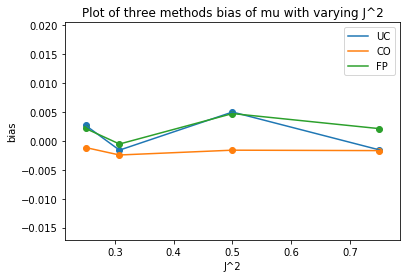

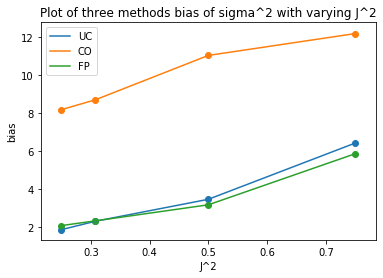

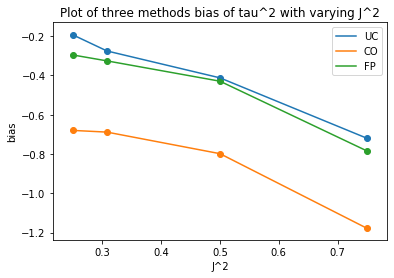

In [186]:
# plot of bias for mu/sigma^2/tau^2
plot_for_comparison('mu','bias','J^2', k=100)
plot_for_comparison('sigma^2','bias','J^2', k=100)
plot_for_comparison('tau^2','bias','J^2', k=100)

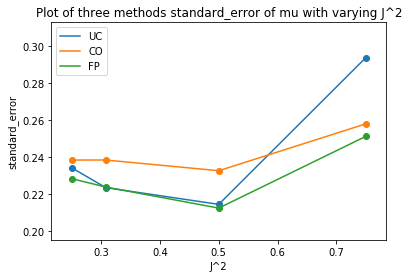

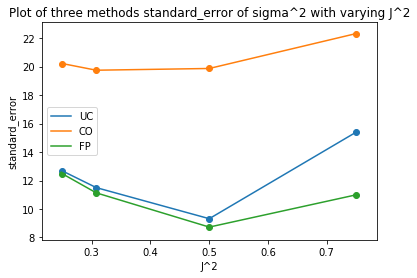

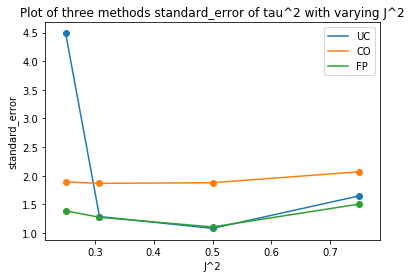

In [187]:
# plot of standard error for mu/sigma^2/tau^2
plot_for_comparison('mu','standard_error','J^2', k=100)
plot_for_comparison('sigma^2','standard_error','J^2', k=100)
plot_for_comparison('tau^2','standard_error','J^2', k=100)

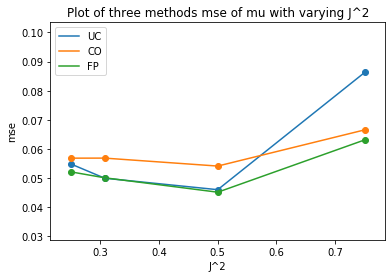

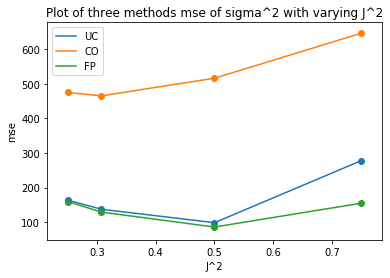

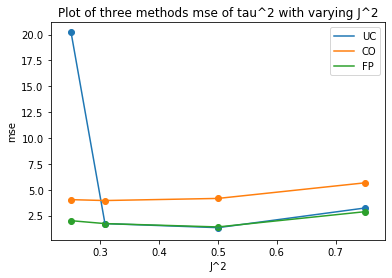

In [185]:
# plot of mse for mu/sigma^2/tau^2
plot_for_comparison('mu','mse','J^2', k=100)
plot_for_comparison('sigma^2','mse','J^2', k=100)
plot_for_comparison('tau^2','mse','J^2', k=100)